# N-dimensional inversion - lithology ratios

Forward and adjoint model of lithology ratios implementation

In [1]:
%matplotlib inline

import numpy as np
import conduction
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from conduction.inversion import InvObservation, InvPrior
from mpi4py import MPI
comm = MPI.COMM_WORLD

In [2]:
minX, maxX = 0.0, 1000.0
minY, maxY = -35e3, 1000.0
nx, ny = 10, 10
n = nx*ny

mesh = conduction.ConductionND((minX, minY), (maxX, maxY), (nx,ny))

# BCs
mesh.boundary_condition('maxY', 298.0, flux=False)
mesh.boundary_condition('minY', 0.04, flux=True)

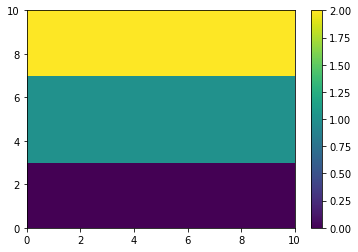

In [3]:
lithology = np.zeros((ny,nx), dtype='int32')
lithology[3:7,:] = 1
lithology[7:,:]  = 2

plt.pcolor(lithology)
plt.colorbar()

# initialise inversion object
inv = conduction.InversionND(lithology.flatten(), mesh)

In [4]:
def construct_lithology(self, ncells):
    lithology_new = np.zeros(self.mesh.n, dtype=np.int)
    
    ncol = self.mesh.n[0]
    
    ncells_int = np.round(ncells).astype(np.int)
    remainder = (ncol - ncells_int.sum(axis=0))
    
    # give remainder (pos/neg) to least cleanly divisible
    distribute = np.argmax(ncells % 1.0, axis=0)
    ncells_int[distribute] += remainder
    
    ncells_pad = np.pad(ncells_int, [[1,0], [0,0]], 'constant')
    ncells_sum = np.cumsum(ncells_pad, axis=0)
    ncells_sum[-1] = ncol
    
    for l, lith in enumerate(self.lithology_index):
        i0 = ncells_sum[l]
        i1 = ncells_sum[l+1]

        for i in xrange(i0.size):
            lithology_new[i0[i]:i1[i],i] = lith
    
    return lithology_new.ravel()

# def construct_lithology_ad(self, ncells, )


def forward_model(x, self, bc='Z'):
    """
    N-dimensional nonlinear model with flux lower BC
    Implements Hofmeister 1999 temperature-dependent
    conductivity law

    Arguments
    ---------
     x : [k_list, H_list, a_list, q0, ratios]

    Returns
    -------
     cost : scalar

    """
    def hofmeister1999(k0, T, a=0.25, c=0.0):
        return k0*(298.0/T)**a + c*T**3
    
    nl = len(self.lithology_index)
    
    k0_list, H_list, a_list = np.split(x[:3*nl], nl)
    q0 = x[3*nl]
    
    # ratios are grouped per lithology (nl, ncol)
    ratios = np.split(x[3*nl+1:], nl)
    
    # normalise all ratios to the range [0,2]
    vratios = np.vstack(ratios)
    vratios /= vratios.sum(axis=0)
    
    # determine number of cells per lithology
    ncells = vratios*self.mesh.n[0]
    deltaZ = ncells*self.grid_delta[-1]
    qs = (H_list.reshape(-1,1)*deltaZ).sum(axis=0)

    
    self.lithology = construct_lithology(self, ncells).ravel()
    k0, H, a = self.map(k0_list, H_list, a_list)
    k = k0.copy()

    self.mesh.update_properties(k0, H)
    self.mesh.boundary_condition("max"+bc, 298.0, flux=False)
    self.mesh.boundary_condition("min"+bc, q0, flux=True)
    rhs = self.mesh.construct_rhs()
    
    error = 10.
    tolerance = 1e-5
    i = 0
    while error > tolerance:
        k_last = k.copy()
        self.mesh.diffusivity[:] = k
        T = self.linear_solve(rhs=rhs) # solve
        k = hofmeister1999(k0, T, a)
        error = np.absolute(k - k_last).max()
        i += 1
        
    q = self.heatflux(T, k)
    delT = self.gradient(T)
    
    cost = 0.0
    cost += self.objective_routine(q=q[0], T=T, delT=delT[0]) # observations
    cost += self.objective_routine(k=k0_list, H=H_list, a=a_list, q0=q0) # priors
    return cost

def adjoint_model(x, self, bc='Z'):
    """
    N-dimensional nonlinear model with flux lower BC
    Implements Hofmeister 1999 temperature-dependent
    conductivity law

    Arguments
    ---------
     x : [k_list, H_list, a_list, q0, ratios]

    Returns
    -------
     cost : scalar
     grad : [dk_list, dH_list, da_list, dq0, dratios]
    """
    def hofmeister1999(k0, T, a=0.25, c=0.0):
        return k0*(298.0/T)**a + c*T**3
    
    nl = len(self.lithology_index)
    
    k0_list, H_list, a_list = np.split(x[:3*nl], nl)
    q0 = x[3*nl]
    
    # ratios are grouped per lithology (nl, ncol)
    ratios = np.split(x[3*nl+1:], nl)
    
    # normalise all ratios to the range [0,2]
    vratios = np.vstack(ratios)
    vratiosum = vratios.sum(axis=0)
    vratios /= vratiosum
    
    # determine number of cells per lithology
    ncells = vratios*self.mesh.n[0]
    deltaZ = ncells*self.grid_delta[-1]
    qs = (H_list.reshape(-1,1)*deltaZ).sum(axis=0)

    
    self.lithology = construct_lithology(self, ncells).ravel()
    k0, H, a = self.map(k0_list, H_list, a_list)
    k = [k0.copy()]
    T = [None]

    self.mesh.update_properties(k0, H)
    self.mesh.boundary_condition("max"+bc, 298.0, flux=False)
    self.mesh.boundary_condition("min"+bc, q0, flux=True)
    rhs = self.mesh.construct_rhs()
    
    error = 10.
    tolerance = 1e-5
    i = 0
    self.mesh.temperature._gdata.set(0.)
    while error > tolerance:
        self.mesh.diffusivity[:] = k[i]
        # solve
        Ti = self.linear_solve(rhs=rhs)
        ki = hofmeister1999(k0, Ti, a)
        T.append(Ti.copy())
        k.append(ki.copy())
        error = np.absolute(k[-1] - k[-2]).max()
        i += 1

    q = self.heatflux(T[-1], k[-1])
    delT = self.gradient(T[-1])
    
    cost = 0.0
    cost += self.objective_routine(q=q[0], T=T[-1], delT=delT[0]) # observations
    cost += self.objective_routine(k=k0_list, H=H_list, a=a_list, q0=q0) # priors
    
    ## AD ##
    dk = np.zeros_like(H)
    dH = np.zeros_like(H)
    dT = np.zeros_like(H)
    da = np.zeros_like(H)
    dk0 = np.zeros_like(H)
    dq0 = np.array(0.0)
    
    # priors
    dcdk_list = self.objective_routine_ad(k=k0)
    dcdH_list = self.objective_routine_ad(H=H)
    dcda_list = self.objective_routine_ad(a=a)
    dcdq0 = self.objective_routine_ad(q0=q0)
    # observations
    dT += self.objective_routine_ad(T=T[-1])

    dq = np.zeros_like(q)
    dq[0] = self.objective_routine_ad(q=q[0])
    
    ddelT = np.zeros_like(delT)
    ddelT[0] = self.objective_routine_ad(delT=delT[0])
    

    dTd = self.gradient_ad(ddelT, T[-1])
    dT += dTd
    
    dTq, dkq = self.heatflux_ad(dq, q, T[-1], k[-1])
    dT += dTq
    dk += dkq
    

    # solve
    for j in range(i):
        dkda = np.log(298.0/T[-1-j])*k0*(298.0/T[-1-j])**a
        dkdk0 = (298.0/T[-1-j])**a
        dkdT = -a*k0/T[-1-j]*(298.0/T[-1-j])**a
        
        dk0 += dkdk0*dk
        dT  += dkdT*dk
        da  += dkda*dk
        
        dk.fill(0.0)
        
        self.mesh.diffusivity[:] = k[-1-j]
        dA, db = self.linear_solve_ad(T[-1-j], dT)
        dk += dA
        dH += -db
        dz = self.grid_delta[-1]
        lowerBC_mask = self.mesh.bc["min"+bc]["mask"]
        dq0 += np.sum(-db[lowerBC_mask]/dz/inv.ghost_weights[lowerBC_mask])
        
        dT.fill(0.0)
        
    dk0 += dk
    
    
    # get surface heat flux derivatives
    dqs = dq[0][self.mesh.bc["max"+bc]["mask"]]
    # this creates a (nl,nx) array
    ddelZ = H_list.reshape(-1,1)*dqs
    dnc = self.grid_delta[-1]*ddelZ
    
    dvrN = self.mesh.n[0]*dnc
    
    dvrNdvrsum = -vratios/(vratiosum**2)
    dvrNdvr = 1.0/vratiosum
    
    dvrsum = dvrNdvrsum*dvrN
    dvr = dvrNdvr*dvrN
    dvr += np.sum(dvrsum, axis=0)


    # pack to lists
    dk_list, dH_list, da_list = inv.map_ad(dk0, dH, da)
    dk_list += dcdk_list
    dH_list += dcdH_list
    da_list += dcda_list
    dq0 += dcdq0
    
    dx = np.hstack([dk_list, dH_list, da_list, [dq0], dvr.ravel()])
    
    return cost, dx

In [5]:
# observations : heat flow

qs = np.ones(nx)*0.03
sigma_qs = qs*0.5
qs_coord = np.zeros((nx,2))
qs_coord[:,0] = inv.mesh.grid_coords[0]
qs_coord[:,1] = 0.0

qobs = InvObservation(qs, sigma_qs, qs_coord)
inv.add_observation(q=qobs)

In [6]:
k = np.array([3.5, 2.0, 3.2])
H = np.array([0.5e-6, 1e-6, 2e-6])
a = np.array([0.3, 0.3, 0.3])
q0 = 35e-3

nl = len(inv.lithology_index)
ratio = np.empty((nl, nx))
ratio[0] = 0.2
ratio[1] = 0.3
ratio[2] = 0.5

dratio = np.zeros((nl, nx))
dratio[0,5:] = -0.1 # change the thickness of the top lithology
dratio[1,5:] = 0.3 # change the thickness of the mid lithology

x  = np.hstack([k, H, a, [q0], ratio.ravel()])
dx = np.hstack([k*0.0, H*0.0, a*0.0, [q0*0.0], dratio.ravel()])

In [7]:
fm0 = forward_model(x, inv, 'Y')
fm1 = forward_model(x+dx, inv, 'Y')
# tl  = tangent_linear(x, dx, ncol, inv)
ad  = adjoint_model(x, inv, 'Y')


print("finite difference {}".format(fm1 - fm0))
# print("tangent linear {}".format(tl[1]))
print("adjoint model {}".format(ad[1].dot(dx)))

ValueError: operands could not be broadcast together with shapes (3,) (100,) (3,) 

In [ ]:
ad[1].shape, dx.shape